In [55]:

import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt4o.csv'
url = f'{base_url}/{relative_url}?raw=1'

df_gpt4o = pd.read_csv(url)

results_gpt4o = df_gpt4o.to_dict(orient="records")


In [56]:
results_gpt4o[0]

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [57]:
record = results_gpt4o[0]

In [64]:

df_gemini = pd.read_csv('data/results-gemini15-pro.csv')
results_gemini = df_gemini.to_dict(orient="records")
results_gemini[0]

{'Unnamed: 0': 0,
 'answer_llm': 'This question is not answerable from the given context. This FAQ section explains how to access course materials, how long the course is, if you can join late, and where to find the course Slack channel. It does not mention where to sign up for the course. \n',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [59]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt35.csv'
url = f'{base_url}/{relative_url}?raw=1'

df_gpt35 = pd.read_csv(url)
results_gpt35 = df_gpt35.to_dict(orient="records")
results_gpt35[0]

{'answer_llm': 'You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

# Cosine similarity

A -> Q -> A' Cosine similarity

We take the answers, generate some questions with an LLM and then use thos questions to get answers with our rag. The we measure the similarity between original aswers and what we got.

cosine(A, A')

In [60]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

c:\Users\User\Documents\llm-zoomcamp-dbeta95\llm-zoomcampt-3.10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [61]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record["answer_llm"]
    
    v_orig = model.encode(answer_orig)
    v_llm = model.encode(answer_llm)
    
    return v_llm.dot(v_orig)

## GPT-4o

In [62]:
from tqdm.auto import tqdm
similarity = [
    compute_similarity(record) for record in tqdm(results_gpt4o)
]

100%|██████████| 1830/1830 [02:39<00:00, 11.44it/s]


In [63]:
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=8)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [17]:
similarity = map_progress(pool, results_gpt4o, compute_similarity)

100%|██████████| 1830/1830 [02:00<00:00, 15.22it/s]


In [28]:
df_gpt4o['cosine'] = similarity

In [29]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course,cosine
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.534533
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.696121
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.717514
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.000328
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.387620


In [33]:
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995338
Name: cosine, dtype: float64

<Axes: xlabel='cosine', ylabel='Count'>

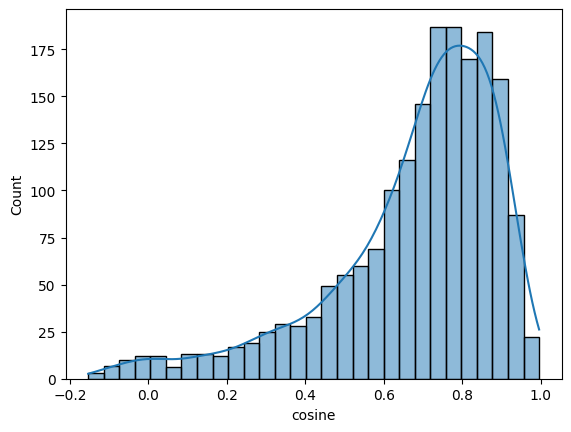

In [38]:
import seaborn as sns

sns.histplot(df_gpt4o['cosine'], kde=True)

## GPT-3.5

In [39]:
from tqdm.auto import tqdm

similarity = [
    compute_similarity(record) for record in tqdm(results_gpt35)
]

100%|██████████| 1830/1830 [02:11<00:00, 13.87it/s]


In [40]:
df_gpt35['cosine'] = similarity

df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

<Axes: xlabel='cosine', ylabel='Count'>

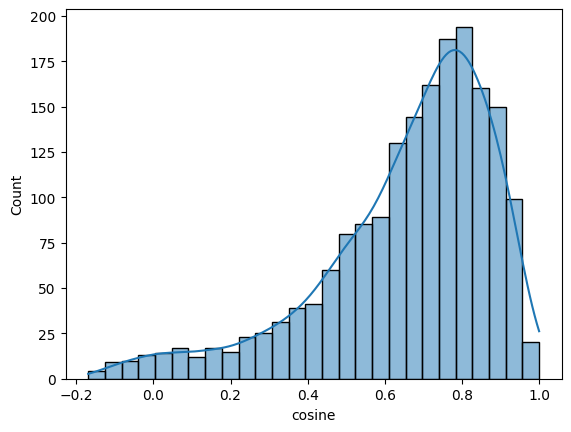

In [41]:
sns.histplot(df_gpt35['cosine'], kde=True)

In [44]:
from scipy import stats

t_stat, p_val = stats.ttest_ind(df_gpt4o['cosine'], df_gpt35['cosine']) 
p_val

0.003381626786670857

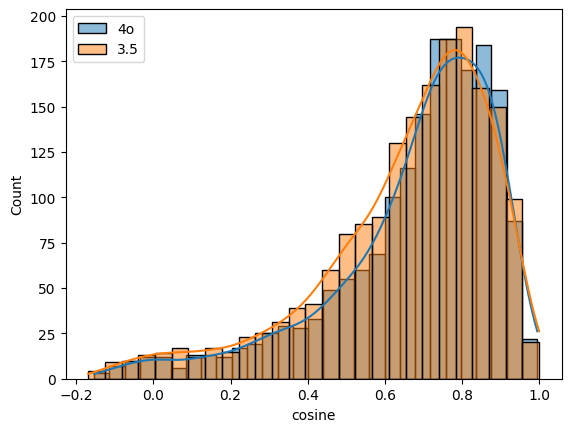

In [46]:
import matplotlib.pyplot as plt

sns.histplot(df_gpt4o['cosine'], kde=True, label = '4o')
sns.histplot(df_gpt35['cosine'], kde=True, label = '3.5')

plt.legend()

## Gemini-1.5



In [65]:
similarity = [
    compute_similarity(record) for record in tqdm(results_gemini)
]

df_gemini['cosine'] = similarity

df_gemini['cosine'].describe()

100%|██████████| 1830/1830 [02:10<00:00, 14.04it/s]


count    1830.000000
mean        0.628151
std         0.225951
min        -0.123564
25%         0.514687
50%         0.675548
75%         0.794805
max         0.998613
Name: cosine, dtype: float64

<Axes: xlabel='cosine', ylabel='Count'>

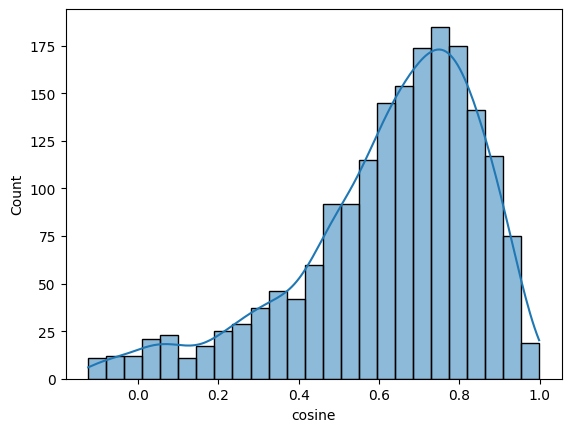

In [66]:
sns.histplot(df_gemini['cosine'], kde=True)

## GPT-4o-mini

In [48]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt4o-mini.csv'
url = f'{base_url}/{relative_url}?raw=1'

df_gpt4o_mini = pd.read_csv(url)

results_gpt4o_mini = df_gpt4o_mini.to_dict(orient="records")

In [49]:
similarity = [
    compute_similarity(record) for record in tqdm(results_gpt4o_mini)
]

df_gpt4o_mini['cosine'] = similarity

df_gpt4o_mini['cosine'].describe()

100%|██████████| 1830/1830 [02:14<00:00, 13.61it/s]


count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

<Axes: xlabel='cosine', ylabel='Count'>

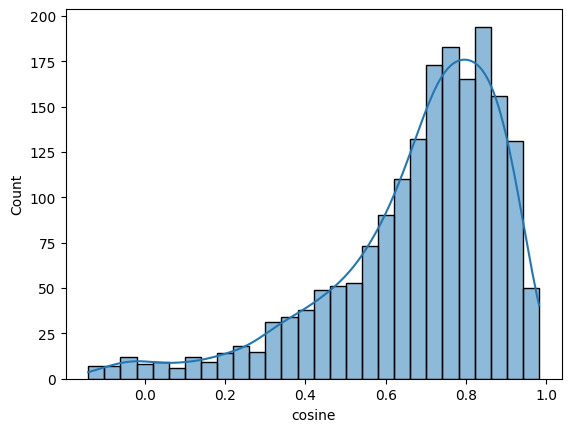

In [51]:
sns.histplot(df_gpt4o_mini['cosine'], kde=True)

In [52]:
t_stat, p_val = stats.ttest_ind(df_gpt4o['cosine'], df_gpt4o_mini['cosine']) 
p_val

0.8668415825042275

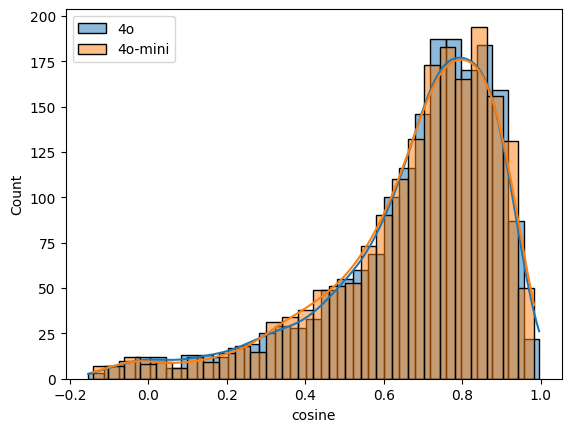

In [54]:
sns.histplot(df_gpt4o['cosine'], kde=True, label = '4o')
sns.histplot(df_gpt4o_mini['cosine'], kde=True, label = '4o-mini')

plt.legend()